## Analyse d'ombre sur un établissement de St denis

In [78]:
# Autoreload des modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [79]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from pathlib import Path
from shapely import Polygon
import pandas as pd
import os, rasterio
from rasterio.plot import show
from potentiel_solaire.features.ombres import getBatimentsEcoles, getOmbre, getBatiments
from potentiel_solaire.features.ombres import get_sun_position
import numpy as np

In [80]:
import warnings
warnings.filterwarnings('ignore') 

In [81]:
# Executer ci dessous ci besoin pour récupérer les données
# !extract-sample-data
# Et pour sauver une version markdown des notebooks, utiliser
# jupyter nbconvert etude_ombres.ipynb --to markdown --output-dir=exports/

### Chargement des Bâtiments et Zones Éducatives

### Pour St Denis

In [82]:
DATA_FOLDER = Path("../data")

saint_denis_path = DATA_FOLDER / "saint_denis_reference_data.gpkg"

ecoles = gpd.read_file(saint_denis_path, layer="bdtopo_education").to_crs(2154)
batiments = gpd.read_file(saint_denis_path, layer="bdtopo_batiment").to_crs(2154)

### Batiments non écoles

In [83]:
tous_batiments = DATA_FOLDER / "BDTOPO_3-4_TOUSTHEMES_GPKG_LAMB93_D093_2024-12-15/BDTOPO/1_DONNEES_LIVRAISON_2024-12-00134/BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15/BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg"


# Création des ombres sur différents jours pour la couche bâtiments

In [84]:
# On charge les couches
ecoles = gpd.read_file(saint_denis_path, layer="bdtopo_education").to_crs(2154)
batiments = gpd.read_file(saint_denis_path, layer="bdtopo_batiment").to_crs(2154)

In [85]:
# Choix d'une école
ID = "SURFACTI0000000002555648"

In [86]:
# Test de l'angle du soleil à une certaine position, date et heure pour les équinoxes et solstices

dates = ["2024-03-21", "2024-06-21", "2024-09-23", "2024-12-21"]    # Equinoxes et solstices
latitude = 42
longitude = 3
heure = 12

for date in dates:
    a, b = get_sun_position(latitude, longitude, date, heure)
    print(f"Date: {date} -> Angle du soleil (a): {a}, Autre valeur (b): {b}") 

Date: 2024-03-21 -> Angle du soleil (a): 48.53860273291222, Autre valeur (b): 181.8834843141007
Date: 2024-06-21 -> Angle du soleil (a): 71.32316440778013, Autre valeur (b): 187.2342545098887
Date: 2024-09-23 -> Angle du soleil (a): 47.39997946241982, Autre valeur (b): 187.33136613950794
Date: 2024-12-21 -> Angle du soleil (a): 24.517363591827216, Autre valeur (b): 183.45508352136397


In [87]:
# Capture des batiments proches
batiments_ecole, ecole_cible, zone = getBatimentsEcoles(ID, ecoles, batiments)
batiments_proches = getBatiments(ID, ecoles, batiments, rayon = 100)
# Et on créé les ombres

In [88]:
zone = ecoles[ecoles.cleabs_left == ID]["geometry"].iloc[0]
buffer_en_m = 50
# Passage en mètres
zone_with_buffer = ecoles[ecoles.cleabs_left == ID].to_crs(epsg=6933)
# Add buffer de 100m
zone_with_buffer = zone_with_buffer.buffer(buffer_en_m) 
# Repassage en Lamb93
zone_with_buffer = zone_with_buffer.to_crs(epsg=2154)

In [89]:
bats = gpd.read_file(tous_batiments, layer="batiment", mask=zone_with_buffer).clip(zone_with_buffer)
bats = bats.to_crs(2154)
ombres = getOmbre(batiments_ecole, bats)

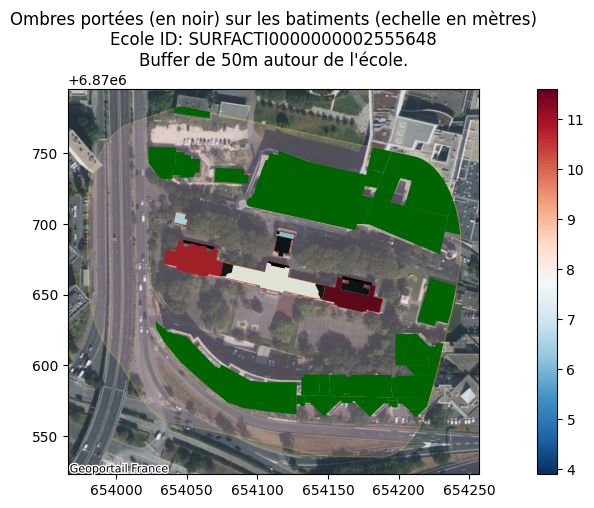

In [90]:
# Et on représente les ombres
fig, ax = plt.subplots(figsize=(15,5))
zone_with_buffer.plot(ax=ax, alpha=0.2, color ="pink", edgecolor='yellow')
batiments_ecole.plot(ax=ax, alpha=0.6, linewidth=1,facecolor="none", edgecolor='red', label="batiments")
bats.plot(ax=ax, alpha=1, color="darkgreen",figsize=(15,5))
batiments_ecole.plot(ax=ax, alpha=0.9,column="hauteur",legend=True,figsize=(15,5),cmap="RdBu_r")
ombres.plot(ax=ax, alpha=0.9, color ="black")
ax.set_title("Ombres portées (en noir) sur les batiments (echelle en mètres)\nEcole ID: "+ID+"\nBuffer de "+str(buffer_en_m)+"m autour de l'école.") 
cx.add_basemap(ax, crs=ecole_cible.crs, source=cx.providers.GeoportailFrance.orthos )
fig.show()

# Exploration des ombres des arbres

On commence par calibrer hauteur de la BD TOPO vs hauteur donnée dans les MNS

In [91]:
batiments_ecole = batiments_ecole.to_crs(epsg=6933)
batiments_ecole["surface_calculee"] = batiments_ecole.area
batiments_ecole = batiments_ecole.to_crs(epsg=2154)
batiments_pour_calibration = batiments_ecole.sort_values(by="surface_calculee",ascending=False).dropna(subset="hauteur")[["cleabs_left__bat","surface_calculee","hauteur","geometry"]]
batiments_pour_calibration

,cleabs_left__bat,surface_calculee,hauteur,geometry
311,BATIMENT0000000243405818,873.041977,7.9,"MULTIPOLYGON Z (((654073.9 6870662.9 41.9, 654..."
314,BATIMENT0000000243405819,648.349874,10.8,"MULTIPOLYGON Z (((654073.9 6870662.9 44.8, 654..."
310,BATIMENT0000000243405820,513.156502,11.6,"MULTIPOLYGON Z (((654145.9 6870646.6 45.6, 654..."
317,BATIMENT0000000243405828,145.074444,6.3,"MULTIPOLYGON Z (((654115.2 6870679.2 40.4, 654..."
312,BATIMENT0000000243405821,133.133387,6.4,"MULTIPOLYGON Z (((654175.6 6870657.5 40.4, 654..."
320,BATIMENT0000000243405871,60.140987,6.8,"MULTIPOLYGON Z (((654049.3 6870706.9 -1000, 65..."
313,BATIMENT0000000243405822,36.643521,4.1,"MULTIPOLYGON Z (((654180.8 6870656.7 38.1, 654..."
319,BATIMENT0000000243405823,34.888313,4.5,"MULTIPOLYGON Z (((654047.4 6870687.2 38.5, 654..."
315,BATIMENT0000000243405817,27.927746,3.9,"MULTIPOLYGON Z (((654107.6 6870672.5 37.9, 654..."
318,BATIMENT0000000243405826,12.541251,6.3,"MULTIPOLYGON Z (((654115.4 6870680.3 40.4, 654..."


In [92]:
import rasterio.mask
from rasterio.features import shapes

On créé un modele de surface autour de l'école.

* Hauteur cf data Batiment ecole:	 7.9
* Hauteur cf data MNS:	 41.835487
* Offset:	 -33.93548736572266


CPLE_AppDefinedError: Deleting ../data/cache/mns/SURFACTI0000000002555648.nobats_masked.tif failed: Permission denied

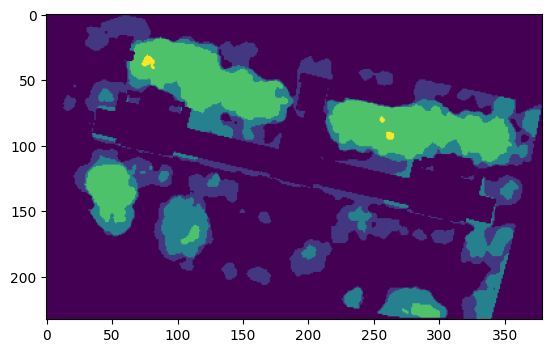

In [93]:
geotiff_cached = "../data/cache/mns/"+ID+".masked.tif"

with rasterio.open(geotiff_cached) as img:
    out_image, out_transform = rasterio.mask.mask(img, batiments_pour_calibration[0:1].geometry, crop=True)
    out_meta = img.meta
offset_hauteur = batiments_pour_calibration[0:1].hauteur.iloc[0] - np.mean(out_image[np.nonzero(out_image)])
print("* Hauteur cf data Batiment ecole:\t", batiments_pour_calibration[0:1].hauteur.iloc[0])
print("* Hauteur cf data MNS:\t", np.mean(out_image[np.nonzero(out_image)]))
print("* Offset:\t",offset_hauteur)
geome = ecole_cible.geometry.total_bounds
A = "0"+str(int(geome[0]//1000))
B = str(int(geome[1]//1000)+1)
tile = "/MNS-Correl_1-0__TIFF_LAMB93_D093_2024-01-01/MNS-Correl/1_DONNEES_LIVRAISON_2024-11-00179/MNS-C_0M50_TIF_LAMB93_D93-2024/93-2024-"+A+"-"+B+"-LA93-0M50.tif"
path = DATA_FOLDER / tile
with rasterio.open("../data/"+str(path)) as img:
    out_image, out_transform = rasterio.mask.mask(img, ecole_cible.geometry, crop=True)
    out_meta = img.meta

out_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform})

with rasterio.open("../data/cache/mns/"+ID+".masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

with rasterio.open("../data/cache/mns/"+ID+".masked.tif") as img:
    out_image, out_transform = rasterio.mask.mask(img, batiments_ecole.geometry, invert=True)
    out_meta = img.meta
out_image = out_image + offset_hauteur
hmin = batiments_pour_calibration.hauteur.min()
out_image = np.where(out_image<hmin*1.05, 0, out_image)

# Essayons d'avoir 3 couches de hauteur
steps = 3
processed = out_image - hmin
hmax = np.max(processed)
G = hmax/steps
OUT = (((processed+G+1)//G)*G)-G+hmin
OUT = np.where(OUT<0, 0, OUT)
plt.imshow(OUT[0])

out_meta.update({"driver": "GTiff",
                "height": OUT.shape[1],
                "width": OUT.shape[2],
                "transform": out_transform})

with rasterio.open("../data/cache/mns/"+ID+".nobats_masked.tif", "w", **out_meta) as dest:
    dest.write(OUT)

with rasterio.open("../data/cache/mns/"+ID+".nobats_masked.tif") as src:
    image = src.read(1)
    imgtoshow = src.read()

img_arbres = rasterio.open("../data/cache/mns/"+ID+".nobats_masked.tif")

On créée ensuite les formes des arbres

In [ ]:
ombres_mns = []
mask = image != 0
results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v)
            in enumerate(
                shapes(image, mask=mask, transform=src.transform)))
for x in results:
    #print(x)
    ombres_mns.append([x["properties"]["raster_val"], Polygon(x["geometry"]["coordinates"][0]) ])
df = pd.DataFrame(ombres_mns,columns = ["hauteur","geometry"])
gdf = gpd.GeoDataFrame(df,geometry="geometry",crs = ecole_cible.crs)
gdf

On réutilise ici la fonction 'getOmbre' avant en passant plutot la forme des arbres (plutot que des batiments)

In [ ]:
ombres_bis = getOmbre(batiments_ecole, gdf)

In [ ]:
# Et on représente les ombres
fig, ax = plt.subplots(figsize=(15,5))
zone_with_buffer.plot(ax=ax, alpha=0.2, color ="pink", edgecolor='yellow')
cx.add_basemap(ax, crs=ecole_cible.crs, source=cx.providers.GeoportailFrance.orthos )
show(img_arbres, ax=ax, alpha=0.7)

bats.plot(ax=ax, alpha=1, color="darkgreen", label="batiments non ecole")
batiments_ecole.plot(ax=ax, alpha=0.6, linewidth=1,facecolor="orange", edgecolor='orange', label="batiments ecole")

ombres_bis.plot(ax=ax, alpha=0.9, color ="grey")
ombres.plot(ax=ax, alpha=0.9, color ="black")

ax.set_title("Ombres des batiments (en noir) et des arbres (en gris) sur les batiments (échelle en mètres)\nEcole ID: "+ID+"\nBuffer de "+str(buffer_en_m)+"m autour de l'école.") 
fig.show()